In [1]:
import os
os.putenv('TF_CPP_MIN_LOG_LEVEL', '2')

import argparse
import copy
import logging
import ray
from ray import tune
import tensorflow as tf

tf.get_logger().setLevel('ERROR')

from muzero.env import wrap_muzero, register_muzero_env
from muzero.muzero import ATARI_DEFAULT_CONFIG
from muzero.trainer import MuZeroTrainer

In [2]:
log = logging.getLogger(__name__)


def update_config(old_config, new_config):
    config = {**old_config}
    for k, v in new_config.items():
        if k in config and isinstance(v, dict):
            config[k] = update_config(config[k], v)
        else:
            config[k] = v
    return config

env_name = 'BreakoutNoFrameskip-MuZero-v1'

config = {
    'env': env_name,
    'action_type': 'atari',
    'num_workers': 4,
    'num_gpus': 1,
    'num_cpus_per_worker': 2,
    'num_gpus_per_worker': 0,
    'memory_per_worker': 6 * 1024**3,
    'object_store_memory_per_worker': 3 * 1024**3,
    'log_level': 'ERROR',
    'learning_starts': 256,
    'timesteps_per_iteration': 512,
    'buffer_size': 100000,
    'mcts': {
        'reset_q_bounds_per_node': True,
        'add_dirichlet_noise': True,
        'dirichlet_epsilon': 0.25,
        'dirichlet_alpha': 0.25,
        # The paper used 50, but showed that it could work with as little as 7
        'num_simulations': 20,
        'argmax_tree_policy': False,
        'puct_c1': 1.25,
        'puct_c2': 19652,
    },
    'optimizer': {
        'num_replay_buffer_shards': 1,
        'debug': False,
    },
}
config = update_config(ATARI_DEFAULT_CONFIG, config)

register_muzero_env('BreakoutNoFrameskip-v4', env_name)

try:
    ray.shutdown()
except:
    pass

#ray.init(local_mode=True)
ray.init(
    num_cpus=9,
    num_gpus=0,
    object_store_memory=20 * 1024**3,
    #_redis_max_memory=5 * 1024**3,
    #_memory=25 * 1024**3
)

2021-02-13 12:26:11,525	INFO resource_spec.py:231 -- Starting Ray with 32.67 GiB memory available for workers and up to 20.0 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-13 12:26:11,957	INFO services.py:1193 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '10.0.128.128',
 'raylet_ip_address': '10.0.128.128',
 'redis_address': '10.0.128.128:6379',
 'object_store_address': '/tmp/ray/session_2021-02-13_12-26-11_494403_114141/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-02-13_12-26-11_494403_114141/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2021-02-13_12-26-11_494403_114141'}

In [8]:
ray.shutdown()

In [3]:

trial = 'MuZeroTrainer_BreakoutNoFrameskip-MuZero-v1_0_2021-01-03_14-22-11hhh589cz'
checkpoint = 38

trainer = MuZeroTrainer(config, env_name)
trainer.load_checkpoint(f'./results/breakout/{trial}/checkpoint_{checkpoint}/checkpoint-{checkpoint}')

Worker 0 initialized.


(pid=114203) 2021-02-13 12:26:16.945401: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
(pid=114197) 2021-02-13 12:26:16.959459: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
(pid=114199) 2021-02-13 12:26:17.010357: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
(pid=114196) 2021-02-13 12:26:16.994469: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
(pid=114200) 2021-02-13 12:26:16.982756: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
(pid=114196) 2021-02-13 12:26:18.274984: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
(pid=114196) 2021-02-13 12:26:18.275769: I tensorflow/st

(pid=114199) Worker 4 initialized.
(pid=114196) Worker 3 initialized.
(pid=114197) Worker 1 initialized.


In [4]:
from IPython import display
from ray.rllib.models.preprocessors import get_preprocessor
from xvfbwrapper import Xvfb
import numpy as np
import time
import pyglet
import gym
import PIL.Image
import io    

from ray.rllib.env.atari_wrappers import MonitorEnv, NoopResetEnv, FireResetEnv, EpisodicLifeEnv, WarpFrame, FrameStack
from ray.rllib.env.atari_wrappers import wrap_deepmind


def play(env_name, agent, steps=1000):
    policy = agent.get_policy()
    
    vdisplay = Xvfb(width=1280, height=740)
    vdisplay.start()

    env = wrap_muzero(gym.make(env_name))
    #prep = get_preprocessor(env.observation_space)(env.observation_space, {'grayscale': True, 'zero_mean': False, 'dim': 84})
    observation = env.reset()
    #four_frames = [prep.transform(observation) for _ in range(3)]
    #action = 1
    #observation, reward, done, info = env.step(action)
    #four_frames.append(prep.transform(observation))
    #for i in range(4):
    #    four_frames.append(prep.transform(observation))
    #    action = policy.action_space.sample()
    #    observation, reward, done, info = env.step(action)
    #full_obs = tf.concat(four_frames, axis=2)

    def showarray(a, fmt='png'):
        a = np.uint8(a)
        f = io.BytesIO()
        ima = PIL.Image.fromarray(a).save(f, fmt)
        return f.getvalue()

    imagehandle = display.display(display.Image(data=showarray(env.render(mode='rgb_array')), width=450), display_id='gymscr')

    action = 0
    reward = 0
    for _ in range(steps):
        time.sleep(0.001)
        action = policy.compute_action(observation, greedy=False)
        observation, reward, done, info = env.step(action)
        
        #del four_frames[0]
        #four_frames.append(prep.transform(observation))
        #full_obs = tf.concat(four_frames, axis=2)
        
        display.update_display(display.Image(data=showarray(env.render(mode='rgb_array')), width=450), display_id='gymscr')
        if done: break

    vdisplay.stop()

(pid=114200) Worker 2 initialized.


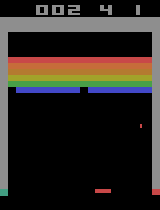

In [6]:
play('BreakoutNoFrameskip-v4', trainer, 1000)